In [27]:
import pandas as pd
import os.path
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
import openpyxl
import re
class StopCell(Exception): # a custom (mute) exception to exit cells programmatically ("raise StopCell")
    def _render_traceback_(self):
        pass

# Analysis Tactile Revcor
&copy; Céline Vanney, Etienne Louyot, JJ Aucouturier, PH Cornuault, Luc Carpentier


## Behavioural data

### Load Behavioural data

In [2]:
for file in glob.glob("./data/behaviour/*results*.csv"):
    print(file)

./data/behaviour\221110_08.22_results_subj6_soft.csv
./data/behaviour\221110_10.41_results_subj7_soft.csv
./data/behaviour\221110_14.16_results_subj8_soft.csv
./data/behaviour\221115_10.24_results_subj9_rug.csv
./data/behaviour\221116_15.47_results_subj10_rug.csv
./data/behaviour\221117_10.16_results_subj11_soft.csv
./data/behaviour\221117_15.45_results_subj12_rug.csv
./data/behaviour\221118_10.35_results_subj13_rug.csv
./data/behaviour\221121_08.55_results_subj14_soft.csv
./data/behaviour\221121_15.48_results_subj15_soft.csv
./data/behaviour\221122_08.42_results_subj16_soft.csv
./data/behaviour\221122_10.23_results_subj17_soft.csv
./data/behaviour\221122_14.05_results_subj18_soft.csv
./data/behaviour\221122_15.52_results_subj19_soft.csv
./data/behaviour\221123_10.28_results_subj20_soft.csv
./data/behaviour\221123_13.37_results_subj21_soft.csv
./data/behaviour\221124_13.36_results_subj22_soft.csv
./data/behaviour\221124_15.54_results_subj23_soft.csv
./data/behaviour\221125_09.06_result

#### Fix condition field & filename

Result files from participant 7 onwards include a `condition` field, and have their condition in the filename. Correct this for earlier participants. 

In [9]:
if True: raise StopCell

conditions = {'1':'rug', '2':'soft', '3':'soft',
             '4':'soft', '5':'soft','6':'soft'}

for participant in [6]: 
    
    # get participant file
    file = glob.glob("./data/behaviour/*results_subj%d*.csv"%participant)[0]
    
    # add condition in pandas
    condition = conditions[str(participant)]
    participant_data = pd.read_csv(file)
    participant_data['condition'] = condition
    
    # and save as new csv file with updated filename
    name, ext = os.path.splitext(os.path.basename(file))
    updated_filename = './data/behaviour/' + name + '_'+ condition + ext
    participant_data.to_csv(updated_filename,index=False)

#### Load all data

In [4]:
data_files = glob.glob("./data/behaviour/*_results_*.csv")
print("got %d behavioural files"%len(data_files))
data_df = pd.DataFrame()
for data_file in data_files:
    participant_data_df = pd.read_csv(data_file, sep = ',', decimal='.', header='infer')
    data_df = pd.concat([data_df, participant_data_df], ignore_index=True)
print('dataframe has %d subjects'%data_df.subj.nunique())

got 22 behavioural files
dataframe has 22 subjects


In [22]:
data_df.groupby(['condition','sex']).subj.unique()

condition  sex
rug        f                                      [9, 10, 12]
           m                                     [13, 26, 27]
soft       f      [6, 11, 14, 15, 16, 18, 21, 22, 23, 24, 25]
           m                               [7, 8, 17, 19, 20]
Name: subj, dtype: object

In [5]:
print("%d textures différentes utilisées"%data_df.texture_id.nunique())

84 textures différentes utilisées


##### Remove skipped blocks

<Axes: xlabel='subj', ylabel='trial'>

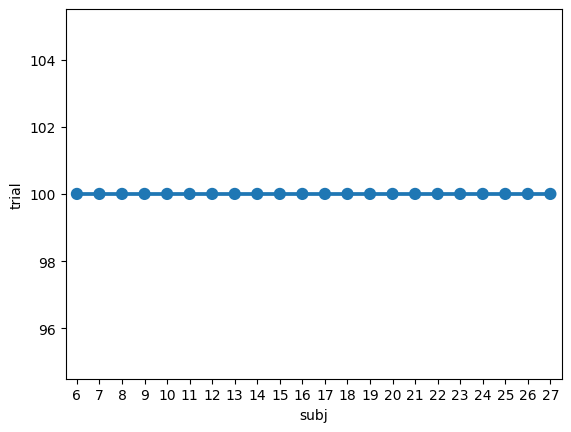

In [25]:
# all subjects have 100 trials
d=data_df[data_df.practice==False].groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

In [7]:
# remove practice block
data_df = data_df[data_df.block.isin([1,2,3,4])]
# data_df = data_df[data_df.practice==False]

In [26]:
data_df.to_csv('data/behaviour/all_data.csv')

##### Number of different textures

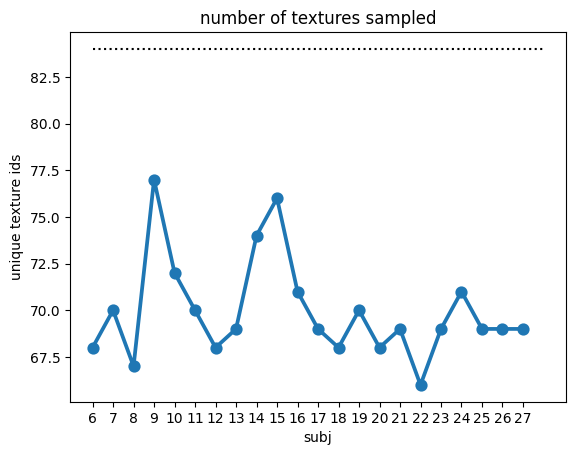

In [9]:
sns.pointplot(data=data_df.groupby('subj', as_index=False).texture_id.nunique(),
              x='subj',y='texture_id')
plt.title('number of textures sampled')
plt.ylabel('unique texture ids')

plt.plot([0,22],[data_df.texture_id.nunique(),data_df.texture_id.nunique()],'k:')


## Load summary meca data

<mark> todo: </mark> faire le même travail que ci-dessus avec les données de meca/summary
- loader les .xls avec read_excel
- concatener les différentes df dans une seule df (2 lignes par trials)
- remettre les mêmes noms de champs que dans all_data.csv (sub, block, trial)
- noms de colonne simples, en format snake_case (lower case with underscores)
- faire des sanity checks avec des groupby (combien de trials par subj, etc.)
- sauver en csv dans meca/summary/all_summary_data.csv

Join les 2 dataframe: pour chaque trial/surface dans behaviour, rajouter les colonnes de summary meca qui correspondent (`behaviour_df.join(summary_meca_df, on=['subj','block','trial','texture'])`)


### Load all data

In [28]:
data_summary = glob.glob("./data/meca/summary/*.xlsx")    
print("got %d summary files"%len(data_summary))
data_df_summary = pd.DataFrame()
for data_sum in data_summary:
    participant_data_summary = pd.read_excel(data_sum,engine="openpyxl")
    data_df_summary = pd.concat([data_df_summary, participant_data_summary], ignore_index=True)
print('dataframe has %d subjects'%data_df_summary.Subject.nunique())

got 9 summary files
dataframe has 23 subjects


In [29]:
data_df_summary.head()

,Date (YYMMDD),Hour [h],Minute [min],Subject,Block,Trial,Texture,Start [s],End [s],Sliding distance [mm],V mean [mm/s],Fn mean [N],Fn std [N],Ft mean [N],Ft std [N],COF mean,COF std,RMS Accelero [m/s²]
0,221122,8,42,16,1,0,1,6.2692,6.8198,37.134524,67.936736,0.244839,0.081262,0.359014,0.075783,1.523927,0.218087,3.381203
1,221122,8,42,16,1,0,2,9.6768,10.3696,37.555220,53.228448,0.354724,0.038919,0.369661,0.026887,1.058695,0.168599,2.619718
2,221122,8,42,16,1,1,1,4.5892,5.2442,32.208557,48.929251,0.510734,0.031468,0.155038,0.012838,0.303306,0.011597,1.254451
3,221122,8,42,16,1,1,2,8.3478,9.2876,35.683789,38.321365,0.378196,0.023547,0.295779,0.043984,0.782811,0.112092,2.044252
4,221122,8,42,16,1,2,1,3.6212,4.4848,35.701824,41.388307,0.464945,0.025050,0.176368,0.016045,0.378981,0.022465,1.067344


### Convert columns names to snake_case

In [31]:
data_df_summary.rename(columns=lambda x: x[0].lower() + x.strip().lower().replace(' ', '_').title()[1:].lower(),inplace=True)  # snake_case
data_df_summary.rename(columns=lambda x: re.sub(r'[^a-z0-9_]', '', x.strip().lower().replace(' ', '_')), inplace=True)

In [32]:
data_df_summary.rename(columns={'subject': 'subj'},inplace=True)

### Sanity checks

<Axes: xlabel='subj', ylabel='trial'>

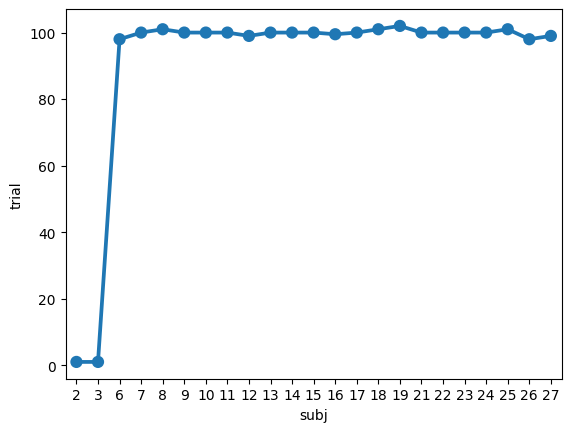

In [36]:
# Trials by subject
d=data_df_summary.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

#### Remove subjects with not many trials

In [75]:
min_trials = 96  # choix arbitraire proche de 100 
filter = data_df_summary.groupby(['subj']).trial.count()/2 
reliable_subjects= filter[filter > min_trials].index   # get subjects who have more tha min_trials
filtered_df = data_df_summary[data_df_summary['subj'].isin(reliable_subjects)]   # another dataset with reliable_subjects only

<Axes: xlabel='subj', ylabel='trial'>

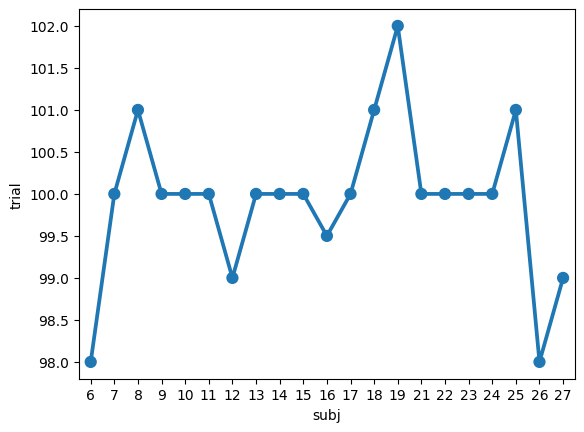

In [76]:
d=filtered_df.groupby(['subj']).trial.count()/2
sns.pointplot(data=d.reset_index(), x='subj',y='trial')

Find duplicates

In [80]:
a = filtered_df.groupby(['subj','block','trial','texture']).subj.count()
a[a>1]

subj  block  trial  texture
6     2      9      1          2
                    2          2
7     1      19     1          2
                    2          2
8     3      13     1          2
                    2          2
15    2      19     1          2
                    2          2
16    2      14     1          2
                    2          2
17    1      18     1          2
                    2          2
      4      3      1          2
                    2          2
18    4      12     1          2
                    2          2
19    2      11     1          2
                    2          2
             22     1          2
                    2          2
21    1      18     1          2
                    2          2
22    1      11     1          2
                    2          2
25    2      0      1          2
                    2          2
             7      1          2
                    2          2
27    1      4      1          3
               

#### Filter v_mean values

<Axes: xlabel='subj', ylabel='v_mean_mms'>

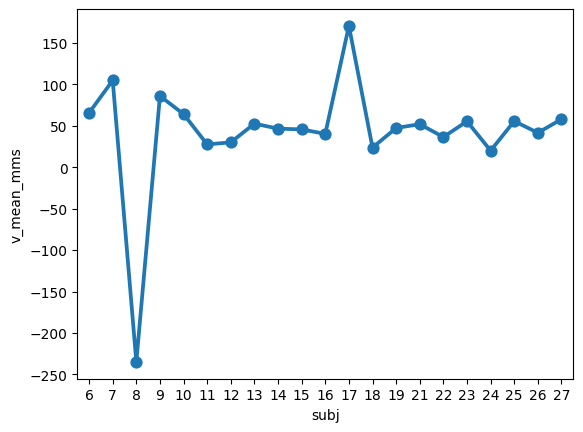

In [11]:
v_mean_by_subject = filtered_df.groupby(['subj'])['v_mean_mms'].mean()   # v_mean() for each subject
sns.pointplot(data=v_mean_by_subject.reset_index(), x='subj',y='v_mean_mms')

In [12]:
# locate rows with not a standard v_mean
v_filter = (filtered_df['v_mean_mms'] > 300) |  (filtered_df['v_mean_mms'] < 0)
filtered_df[v_filter] 

,date_yymmdd,hour_h,minute_min,subj,block,trial,texture,start_s,end_s,sliding_distance_mm,v_mean_mms,fn_mean_n,fn_std_n,ft_mean_n,ft_std_n,cof_mean,cof_std,rms_accelero_ms
83,221122,8,42,16,3,0,1,0.2680,0.4612,-189.179291,-406.446715,-0.001045,0.009138,-0.000201,0.000866,0.024723,1.524940,0.597579
84,221122,8,42,16,3,0,2,0.8334,1.0054,-42.073049,-759.093773,-0.001654,0.008313,-0.000204,0.000550,0.028285,1.723719,1.089030
129,221122,8,42,16,4,0,1,0.3510,0.6732,128.008126,-102.126788,-0.000891,0.011209,-0.000113,0.001044,0.099480,2.912515,0.472312
231,221122,10,23,17,1,16,1,0.3462,0.3812,24.990426,1471.152509,0.003755,0.007496,-0.004445,0.001858,-1.185046,5.601719,0.125029
232,221122,10,23,17,1,16,2,0.4854,0.5008,142.611718,13463.971511,-0.003674,0.005389,-0.008271,0.001098,2.566126,14.246778,0.123659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,221110,8,22,6,1,2,2,3.7298,4.0166,-1.209241,-1.427792,0.528894,0.041373,0.492902,0.038785,0.941459,0.131747,0.270764
2810,221110,8,22,6,1,3,2,4.0290,4.3712,-1.223049,-1.898012,0.687975,0.113679,0.073072,0.093514,0.084463,0.147489,0.036058
2846,221110,8,22,6,2,2,2,5.3024,5.5668,-86.464887,3822.601132,0.000521,0.007273,-0.000127,0.001059,0.816711,27.645549,0.370926
2856,221110,8,22,6,2,7,2,4.5780,4.7136,-6.499239,1324.218499,0.398860,0.309992,0.014210,0.054666,-0.351170,13.392552,2.367558


In [13]:
# A new dataframe with only standard v_mean
df_adjusted_v_mean = filtered_df[~v_filter] 

<Axes: xlabel='subj', ylabel='v_mean_mms'>

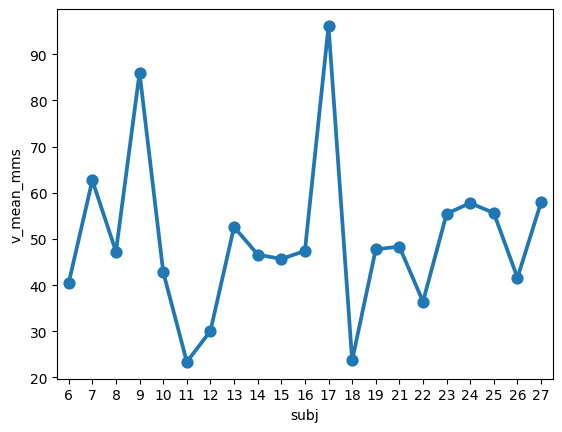

In [14]:
v_mean_std_by_subject = df_adjusted_v_mean.groupby(['subj'])['v_mean_mms'].mean()   # v_mean() for each subject
sns.pointplot(data=v_mean_std_by_subject.reset_index(), x='subj',y='v_mean_mms')

#### Subjects with high fn_mean

C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_19228\135359930.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(data_df_summary.subj.nunique(),1,ind+1)


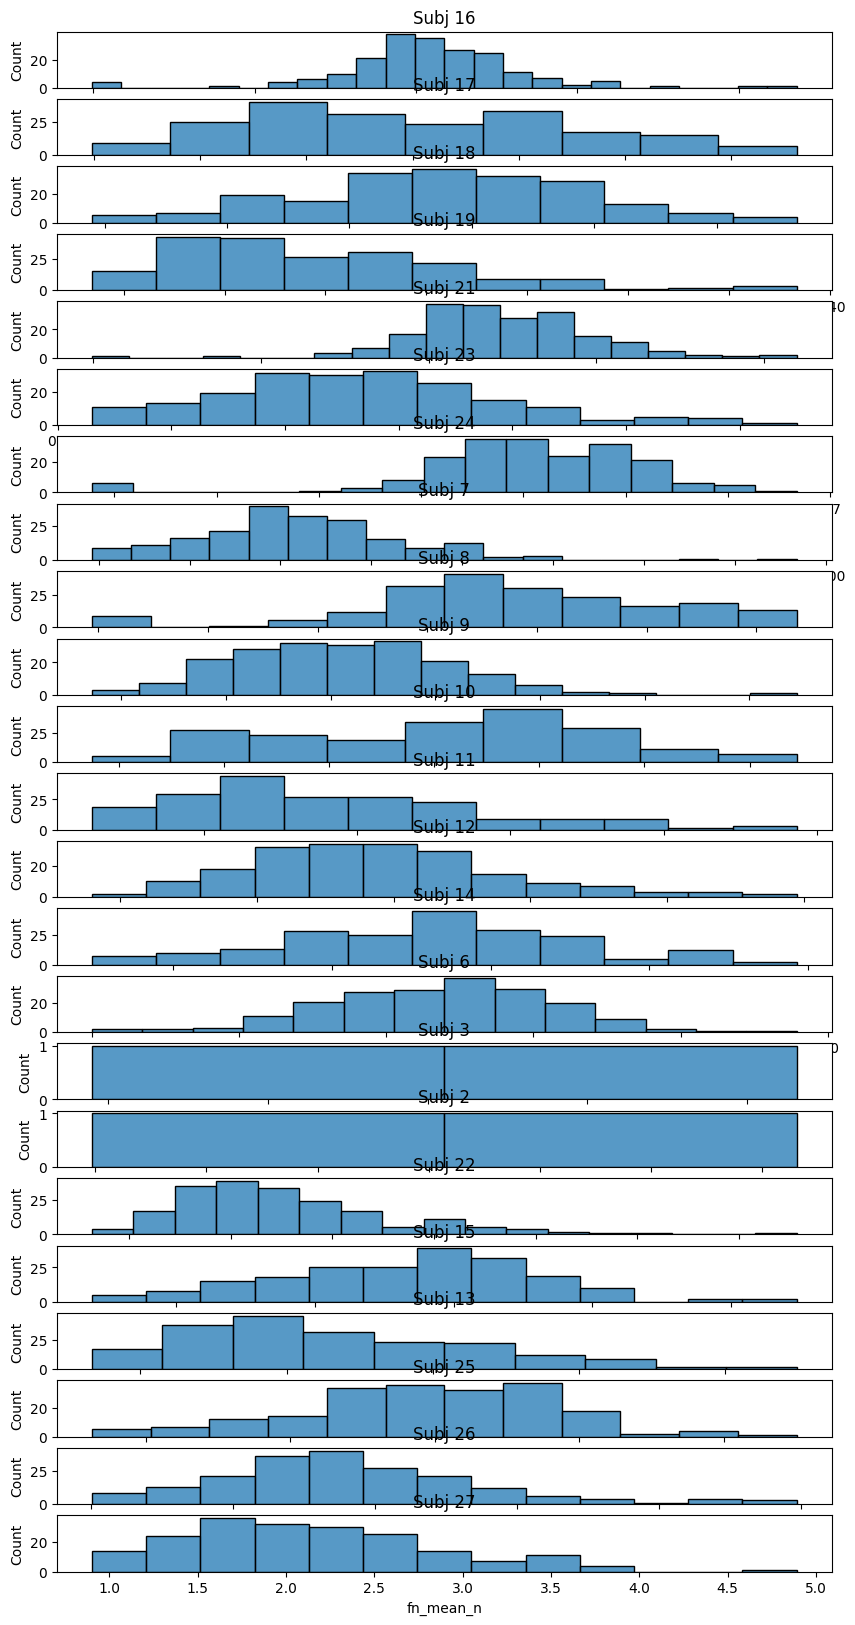

In [96]:
subjs = data_df_summary.subj.unique()
plt.subplots(figsize=(10,20))
for ind, subj in enumerate(subjs): 
    plt.subplot(data_df_summary.subj.nunique(),1,ind+1)
    sns.histplot(data=data_df_summary[data_df_summary.subj==subj],
                 x='fn_mean_n', label='%s'%subj)
    plt.title('Subj %s'%subj)
    


<Axes: xlabel='subj', ylabel='fn_mean_n'>

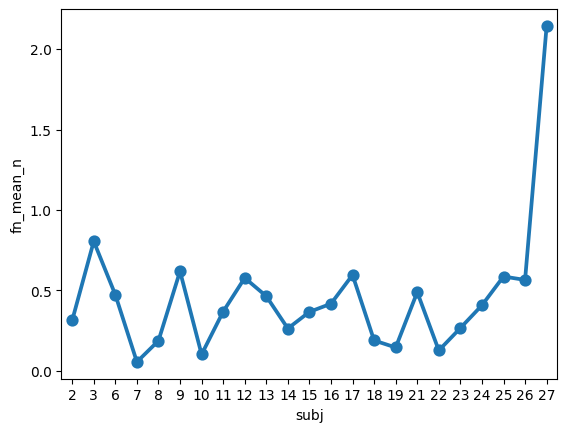

In [15]:
fn_mean_std_by_subject = data_df_summary.groupby(['subj'])['fn_mean_n'].mean()   # fn_mean() for each subject
sns.pointplot(data=fn_mean_std_by_subject.reset_index(), x='subj',y='fn_mean_n')

In [17]:
df_adjusted_v_mean.to_csv('data/meca/all_data.csv')

<mark> done: </mark> 
- data loaded
- columns names changed to snake_case
- a new dataframe created (filtered_df) without subject 2 and 3
- a new dataframe created (df_adjusted_v_mean) with only standard v_mean values 
- display fn_mean by subject
- All data saved from (df_adjusted_v_mean) dataframe

<mark> TODO: 
    
    - vérifier les valeurs de v_mean etc. pour les trials duplicate    
    - si elles sont comparables, faire groupby.mean()
    - continuer de regarder les valeurs outliers sur toutes les colonnes summary (min, max, groupby.describe(), sns.hist)
    - filtrer les valeurs aberrantes
    
    - sauver dans meca_csv
    - join avec behaviour

## Kernel

### Kernel computation

In [10]:
data_melt = pd.melt(data,
        id_vars=['subj','trial','block','sex','age','condition','response'],
        value_vars=['diameter','opening','spacing'],
        var_name='feature')

# z-score feature values
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)
# zscore TAS and weights
data_melt['value'] = data_melt.groupby(['subj','feature'])['value'].transform(zscore) 

# compute difference between positives and negatives in each trial
positives = data_melt.loc[data_melt.response == True].reset_index()
negatives = data_melt.loc[data_melt.response == False].reset_index()
kernels = pd.merge(positives, negatives, on=['subj','block','trial','feature'],suffixes=['+','-'])
kernels['delta_value']=kernels['value+']-kernels['value-']

kernels.drop(['index+','response+', 'value+', 
               'index-', 'sex-', 'age-', 'condition-', 'response-', 'value-'], axis=1, inplace=True)
kernels = kernels.rename(columns={'sex+':'sex','age+':'age', 'condition+':'condition'})

# normalize for each subj by dividing by the RMS of their values over all trials 
kernels['square_delta_value'] = kernels['delta_value']**2

for_norm = kernels.groupby(['subj','condition','feature']).agg({'square_delta_value':'mean'}).reset_index()
                                          
kernels = pd.merge(kernels, for_norm, on=['subj','condition','feature'], suffixes=['','_mean'])
kernels['norm_delta_value'] = kernels['delta_value']/np.sqrt(kernels['square_delta_value_mean'])

kernels.drop(['delta_value','square_delta_value', 'square_delta_value_mean',], axis=1, inplace=True)


NameError: name 'data' is not defined

### Different kernels per condition

In [ ]:
kernels.groupby(['condition','feature']).norm_delta_value.mean()

condition  feature 
rug        diameter   -0.006298
           opening     0.613785
           spacing     0.294076
soft       diameter   -0.121706
           opening    -0.510029
           spacing    -0.342440
Name: norm_delta_value, dtype: float64

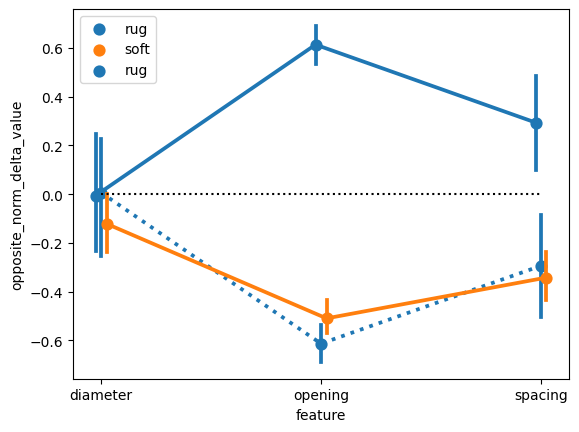

In [ ]:
sns.pointplot(data=kernels,
              hue="condition",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

# plot inverse rough kernel for comparison
kernels['opposite_norm_delta_value'] = - kernels.norm_delta_value
sns.pointplot(data=kernels[kernels.condition=='rug'],
              hue="condition",
             x="feature",
              units='subj',
             y="opposite_norm_delta_value", 
              linestyles=[':'])

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

One-sample difference of kernel weights to zero

In [ ]:
print("One-sample difference of kernel weights to zero")
for condition in ['rug','soft']:
    print('%s:'%condition.upper())
    for feature in ['diameter','opening','spacing']: 
        
        print('- %s'%(feature))
        
        sample = kernels[(kernels.condition==condition)&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
        
        stats= pg.ttest(x=sample.norm_delta_value, y=0)
        print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

One-sample difference of kernel weights to zero
RUG:
- diameter
t(6)=-0.05,p=0.9618
- opening
t(6)=20.43,p=0.0000
- spacing
t(6)=2.70,p=0.0358
SOFT:
- diameter
t(19)=-1.97,p=0.0632
- opening
t(19)=-17.80,p=0.0000
- spacing
t(19)=-6.72,p=0.0000


Two-sample difference of kernel weights between soft and non-rough

In [ ]:
print("Two-sample difference of kernel weights between soft and non-rough")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_soft = kernels[(kernels.condition=='soft')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_rug = kernels[(kernels.condition=='rug')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_soft.norm_delta_value, 
                    y=-sample_rug.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between soft and non-rough
- diameter
t(9)=-0.91,p=0.3853
- opening
t(17)=2.50,p=0.0228
- spacing
t(8)=-0.40,p=0.6976


### Sex difference for soft

In [ ]:
data.groupby(['condition','sex']).subj.nunique()

condition  sex
rug        f       3
           m       4
soft       f      12
           m       8
Name: subj, dtype: int64

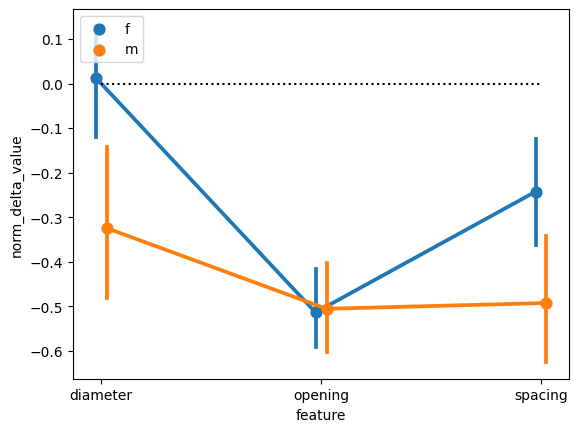

In [ ]:
sns.pointplot(data=kernels[kernels.condition=='soft'],
              hue="sex",
             x="feature",
              units='subj',
             y="norm_delta_value", dodge=True)

plt.plot([0,2],[0,0],'k:')
plt.legend(loc=2)

In [ ]:
print("Two-sample difference of kernel weights between male and female soft")
for feature in ['diameter','opening','spacing']: 
    print('- %s'%(feature))
      
    sample_male = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='m')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()

    sample_female = kernels[(kernels.condition=='soft')&
                          (kernels.sex=='f')&
                          (kernels.feature==feature)].groupby(['subj'], as_index=False).norm_delta_value.mean()
    
    stats= pg.ttest(x=sample_male.norm_delta_value, 
                    y=sample_female.norm_delta_value)
    
    print('t(%d)=%.2f,p=%.4f'%(stats.loc['T-test','dof'],
                               stats.loc['T-test','T'],
                               stats.loc['T-test','p-val']))

Two-sample difference of kernel weights between male and female soft
- diameter
t(13)=-3.17,p=0.0073
- opening
t(15)=0.14,p=0.8934
- spacing
t(14)=-2.77,p=0.0145


Remember that the first few participants (3 ?) had a bug that resulted in not stopping the recording at the time of response

(-0.01, 0.05)

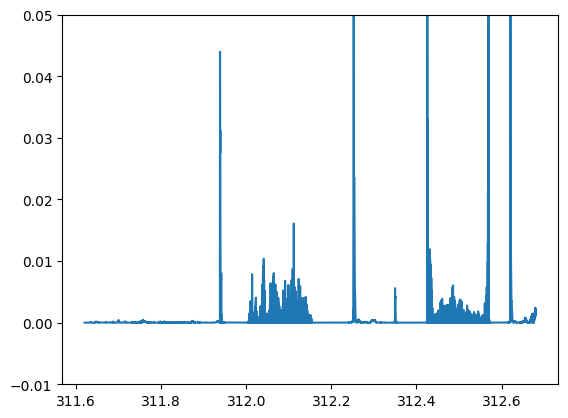